### Log Anomlay Detector Core Mininimal Implementation

In an effort to help new users and contributors understand the core Machine Learning elements of the log anomaly detector I have decided to recreate a streamlined minimal version. Here we will ignore any streaming or external aspect of our data and use a fixed local data file for simplicity and reproducability.   

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomlay Scores
* Model Inference /Prediction

For the most part function names have been made to match their relevent counter part in the larger code base.

My aim for this notebook is that, by the end a reader will 1) have a clear understanding of how the current implementation works and 2) know where to make changes to try another approach. 

### Import our packages

In [1]:
import os
import time
import numpy as np
import logging
import sompy
from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt


CACHEDIR=/home/nadzya/.cache/matplotlib
Using fontManager instance from /home/nadzya/.cache/matplotlib/fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
NumExpr defaulting to 4 threads.


In [2]:
# import sys
# sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [3]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [4]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [5]:
def train(inp, map_size, iterations, parallelism):
    print(f'training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [6]:
def get_anomaly_score(logs, parallelism, model):

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters):
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [7]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocesses. Here was can see this is a rather small example, with 10,000 log lines, but only 3 unique log messages

In [8]:
data_path = r"file:///home/nadzya/Apps/log-anomaly-detector/validation_data/log_anomaly_detector-10000-events.json"

In [9]:
data = pd.read_json(data_path, orient=str)

In [10]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [11]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [12]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

DEBUGProcessedoutofpackages 9786
ThreadodcsserverINFOComposetypestatedoneComposedone 213
rootCMDusrlocalbinmonitorapachestatsshdevnull 1


In [13]:
data

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages
...,...
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages


#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with thier vectorized representation. 

In [14]:
w2vmodel = create(data, 100, 3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
effective_min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 100 dimensions: 3900 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 68754 effective words/s
worker exiting, processed 1 jobs
job loop exiting, total 1 jobs
worker exiting, processed 

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 35 : training on 10000 raw words (366 effective words) took 0.0s, 98460 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 36 : training on 10000 raw words (354 effective words) took 0.0s, 34594 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 37 : training on 10000 raw words (381 effective words) took 0.0s, 49166 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 38 : training on 10000 raw words (378 effective words) took 0.0s, 189673 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threa

worker thread finished; awaiting finish of 0 more threads
EPOCH - 72 : training on 10000 raw words (376 effective words) took 0.0s, 54585 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 73 : training on 10000 raw words (395 effective words) took 0.0s, 134972 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 74 : training on 10000 raw words (349 effective words) took 0.0s, 52232 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 75 : training on 10000 raw words (381 effective words) took 0.0s, 47320 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 76 : training on 10000 raw words (366 effective words

EPOCH - 109 : training on 10000 raw words (354 effective words) took 0.0s, 71182 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 110 : training on 10000 raw words (403 effective words) took 0.0s, 66514 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 111 : training on 10000 raw words (384 effective words) took 0.0s, 40801 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 112 : training on 10000 raw words (365 effective words) took 0.0s, 85392 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 113 : training on 10000 raw words (400 effective words) took 0.0s, 87795 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 147 : training on 10000 raw words (401 effective words) took 0.0s, 53243 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 148 : training on 10000 raw words (364 effective words) took 0.0s, 36043 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 149 : training on 10000 raw words (361 effective words) took 0.0s, 41541 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 150 : training on 10000 raw words (400 effective words) took 0.0s, 64507 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 184 : training on 10000 raw words (378 effective words) took 0.0s, 77950 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 185 : training on 10000 raw words (383 effective words) took 0.0s, 87229 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 186 : training on 10000 raw words (416 effective words) took 0.0s, 146456 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 187 : training on 10000 raw words (373 effective words) took 0.0s, 44319 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 188 : training o

worker thread finished; awaiting finish of 0 more threads
EPOCH - 221 : training on 10000 raw words (394 effective words) took 0.0s, 52158 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 222 : training on 10000 raw words (386 effective words) took 0.0s, 49435 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 223 : training on 10000 raw words (407 effective words) took 0.0s, 98000 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 224 : training on 10000 raw words (355 effective words) took 0.0s, 59588 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 225 : training on 10000 raw words (360 effective w

EPOCH - 258 : training on 10000 raw words (378 effective words) took 0.0s, 51930 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10000 raw words (371 effective words) took 0.0s, 46519 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10000 raw words (370 effective words) took 0.0s, 92814 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10000 raw words (396 effective words) took 0.0s, 37460 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10000 raw words (397 effective words) took 0.0s, 83033 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 296 : training on 10000 raw words (380 effective words) took 0.0s, 97849 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 297 : training on 10000 raw words (382 effective words) took 0.0s, 59236 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 298 : training on 10000 raw words (383 effective words) took 0.0s, 94853 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 299 : training on 10000 raw words (379 effective words) took 0.0s, 44633 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 333 : training on 10000 raw words (370 effective words) took 0.0s, 49395 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 334 : training on 10000 raw words (389 effective words) took 0.0s, 53378 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 335 : training on 10000 raw words (412 effective words) took 0.0s, 90493 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 336 : training on 10000 raw words (358 effective words) took 0.0s, 50313 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 337 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10000 raw words (348 effective words) took 0.0s, 69246 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 371 : training on 10000 raw words (353 effective words) took 0.0s, 18888 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 372 : training on 10000 raw words (393 effective words) took 0.0s, 69555 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 373 : training on 10000 raw words (379 effective words) took 0.0s, 40197 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 374 : training on 10000 raw words (370 effective w

EPOCH - 407 : training on 10000 raw words (372 effective words) took 0.0s, 58702 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 408 : training on 10000 raw words (383 effective words) took 0.0s, 60606 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 409 : training on 10000 raw words (379 effective words) took 0.0s, 122660 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 410 : training on 10000 raw words (375 effective words) took 0.0s, 98052 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 411 : training on 10000 raw words (385 effective words) took 0.0s, 76460 effective words/s
job loop exiting

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 445 : training on 10000 raw words (378 effective words) took 0.0s, 89940 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 446 : training on 10000 raw words (396 effective words) took 0.0s, 24122 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 447 : training on 10000 raw words (376 effective words) took 0.0s, 84853 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 448 : training on 10000 raw words (394 effective words) took 0.0s, 53418 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 482 : training on 10000 raw words (370 effective words) took 0.0s, 36240 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 483 : training on 10000 raw words (387 effective words) took 0.0s, 415531 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 484 : training on 10000 raw words (412 effective words) took 0.0s, 81476 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 485 : training on 10000 raw words (387 effective words) took 0.0s, 110408 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 486 : training 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10000 raw words (381 effective words) took 0.0s, 56211 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10000 raw words (351 effective words) took 0.0s, 28275 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10000 raw words (369 effective words) took 0.0s, 32823 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10000 raw words (398 effective words) took 0.0s, 36429 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10000 raw words (363 effective w

In [15]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a few vizualiztions of the trained model

In [16]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

 Training...
 random_initialization took: 0.004000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.139000, quantization error: 35.700666



training dataset is of size 10000


 epoch: 2 ---> elapsed time:  0.155000, quantization error: 1.591719

 epoch: 3 ---> elapsed time:  0.126000, quantization error: 0.119609

 epoch: 4 ---> elapsed time:  0.120000, quantization error: 0.105119

 epoch: 5 ---> elapsed time:  0.113000, quantization error: 0.095055

 epoch: 6 ---> elapsed time:  0.123000, quantization error: 0.085710

 epoch: 7 ---> elapsed time:  0.122000, quantization error: 0.077065

 epoch: 8 ---> elapsed time:  0.153000, quantization error: 0.069098

 epoch: 9 ---> elapsed time:  0.107000, quantization error: 0.061785

 epoch: 10 ---> elapsed time:  0.121000, quantization error: 0.055099

 epoch: 11 ---> elapsed time:  0.118000, quantization error: 0.049009

 epoch: 12 ---> elapsed time:  0.108000, quantization error: 0.043178

 epoch: 13 ---> elapsed time:  0.106000, quantization error: 0.038186

 epoch: 14 ---> elapsed time:  0.111000, quantization error: 0.033698

 epoch: 15 ---> elapsed time:  0.101000, quantization error: 0.029680

 epoch: 16 ---

<ipython-input-17-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-17-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-17-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-17-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) f

[-24728.71763717961, -1.856636027359204, -8.101136424095017e-25, -7.6957554485297155e-25, -7.6788162775888385e-25, -7.6957554485297155e-25, -8.159185040769267e-25, -7.6957554485297155e-25, -7.6957554485297155e-25]


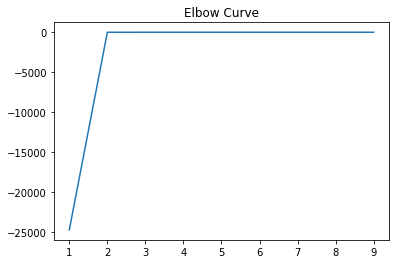

In [17]:
# First implementation for K-means with sklearn 
# (using Euclidean distance without normalization)
from sklearn.cluster import KMeans;
import matplotlib.pyplot as pl
n = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in n]
kmeans
score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
print(score)
pl.plot(n,score)
pl.title('Elbow Curve')
pl.show()

In [18]:
n_cluster = 2
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', n_init= 20, max_iter=300, algorithm="auto")

#cluster index vector
index = kmeans.fit_predict(transformed_data)
print(index)

# Distance matrix
dist = kmeans.fit_transform(transformed_data)
print(dist)

np.unique(kmeans.labels_)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in kmeans.labels_)
# number of 0: 9787
sum(i == 0 for i in kmeans.labels_)

[0 0 0 ... 0 0 0]
[[1.39231009e-04 1.08911845e+01]
 [1.39231009e-04 1.08911845e+01]
 [1.39231009e-04 1.08911845e+01]
 ...
 [1.39231009e-04 1.08911845e+01]
 [1.39231009e-04 1.08911845e+01]
 [1.39231009e-04 1.08911845e+01]]


9787

In [38]:
# Second implementation for K-means with sklearn
# (Using Cosine similarity)
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(n_cluster, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters= True)
labels = kclusterer.cluster(transformed_data, assign_clusters=True)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in labels)
# number of 0: 9787
sum(i == 0 for i in labels)

213

In [39]:
# from sompy.visualization.hitmap import HitMapView
# model.cluster(3)
# hits  = HitMapView(10,10,"Clustering",text_size=7)
# a=hits.show(model, labelsize=12)

In [40]:
# from sompy.visualization.mapview import View2D
# view2D  = View2D(10,10,"rand data",text_size=10)
# view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

In [41]:
# from sompy.visualization.bmuhits import BmuHitsView

# vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
# vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [42]:
m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [43]:
%qtconsole

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [44]:
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

0.21184982384558915
0.19519609387788772
0.19711245003107097
0.002174186546823392


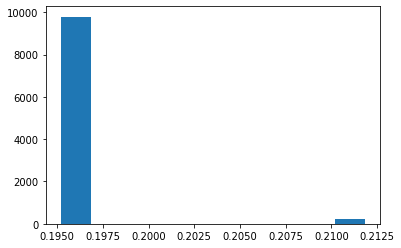

In [45]:
plt.hist(distances)
plt.show()

In [46]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

0.20363500967154116

In [48]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6722, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6723, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6724, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6725, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6726, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6727, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6728, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6729, dtype: object
0.21184982384558915 message    ThreadodcsserverINFOComposetypestatedoneCompos...
Name: 6730, dtype: object
0.21184982384558915 message    Thread

In [49]:
data.message.value_counts()

DEBUGProcessedoutofpackages                            9786
ThreadodcsserverINFOComposetypestatedoneComposedone     213
rootCMDusrlocalbinmonitorapachestatsshdevnull             1
Name: message, dtype: int64

#### Test 

In [50]:
help(infer)

Help on function infer in module __main__:

infer(w2v, som, log, data, threshold)



In [51]:
infer(w2vmodel, m, 'root CMD usr local bin monitor apache stats sh dev null', data, threshold)

(0, [0.19519610043659408])

In [52]:
infer(w2vmodel,m,'DEBUG Processed out of packages', data,threshold)

(0, [0.19679188635187173])

In [53]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

(1, [0.21184981208467957])

In [54]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 196805 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 130933 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 150947 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 304864 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 444204 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 455587 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 142526 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 498479 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 321738 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 125806 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 154121 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 170876 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 152401 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 133513 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 119139 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 141954 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 676741 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 422980 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 466182 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 183803 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 390803 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 325743 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 62043 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 160178 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 171370 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effect

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 139019 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 177807 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 133605 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 128583 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 149486 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 282186 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effec

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 138896 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 493191 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 170085 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 540705 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 129962 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 378018 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 380330 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 182793 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 131941 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 361208 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 130516 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 136357 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 206861 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 170193 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 154927 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 146867 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 135945 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 418317 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 87520 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 130722 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 112731 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 124574 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 135895 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 214206 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effect

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 527578 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 157926 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 169124 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 421297 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 182488 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 172892 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.4114766044369771])

In [55]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 79732 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) t

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 327701 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 96392 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 148980 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 136350 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 511429 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 283906 effective words/s
worker thread finished; awaiting finish of 0 more threads
E

EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 199492 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 118790 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 133120 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 349956 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 136419 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 502454 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 193735 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 457762 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 144015 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 509614 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 585556 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 577413 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 238595 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 261711 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 116199 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 120076 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 113671 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 120388 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effec

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 250331 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 453825 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 113341 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 182650 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 365396 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 148982 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effec

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 186465 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 318949 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 169045 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 330933 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 467867 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 195296 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 131208 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 338031 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 140277 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 283000 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 187797 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 217041 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 209801 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 443829 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 282370 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 426975 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 134945 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 204770 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 118563 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 132260 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 175609 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 112508 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 107458 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 124648 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effec

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 288799 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 176089 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 160690 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 120704 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 130343 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 145631 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.4128719674921225])

In [56]:
infer(w2vmodel,m,'message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 136561 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 158354 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 158796 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 180000 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 158845 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 160225 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 147769 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 102398 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 119731 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 400020 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 324540 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 139658 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 237586 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effec

EPOCH - 153 : training on 10001 raw words (361 effective words) took 0.0s, 439955 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 533897 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 146308 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 163859 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 150140 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 390208 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effec

EPOCH - 205 : training on 10001 raw words (431 effective words) took 0.0s, 183644 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 155032 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 154722 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 375430 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 557567 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 131376 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effec

EPOCH - 257 : training on 10001 raw words (373 effective words) took 0.0s, 168202 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 258 : training on 10001 raw words (378 effective words) took 0.0s, 131671 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 49347 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 94769 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 154967 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 43252 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effectiv

EPOCH - 309 : training on 10001 raw words (420 effective words) took 0.0s, 179778 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 310 : training on 10001 raw words (366 effective words) took 0.0s, 452748 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 176419 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 491652 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 183833 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 493788 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effec

EPOCH - 361 : training on 10001 raw words (407 effective words) took 0.0s, 351960 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 362 : training on 10001 raw words (390 effective words) took 0.0s, 451550 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 415312 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 178949 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 104507 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 322328 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effec

EPOCH - 413 : training on 10001 raw words (421 effective words) took 0.0s, 145934 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 414 : training on 10001 raw words (404 effective words) took 0.0s, 332613 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 415 : training on 10001 raw words (386 effective words) took 0.0s, 151489 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 122438 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 147568 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 478724 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effec

EPOCH - 465 : training on 10001 raw words (376 effective words) took 0.0s, 156882 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 466 : training on 10001 raw words (407 effective words) took 0.0s, 143937 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 467 : training on 10001 raw words (411 effective words) took 0.0s, 367555 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 136966 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 488955 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 60815 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effect

EPOCH - 517 : training on 10001 raw words (383 effective words) took 0.0s, 415079 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 518 : training on 10001 raw words (388 effective words) took 0.0s, 175598 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10001 raw words (392 effective words) took 0.0s, 143464 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10001 raw words (400 effective words) took 0.0s, 170647 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 196380 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 135930 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effec

(1, [0.41011471758609486])